# Dogs vs. Cats Redux: Kernels Edition

## Initial configuration

Show plots in the web page itself:

In [10]:
# Define path to data.
%matplotlib inline 

# Define path to data.
path = "data/sample/" 

In [11]:
from utils import plots

## Using a pretrained VGG model with the vgg16 class to finetune Dogs vs Cat model

In [12]:
from vgg16 import Vgg16

vgg = Vgg16()
batch_size = 64

batches = vgg.get_batches(path + 'train', batch_size = batch_size)
valid_batches = vgg.get_batches(path + 'valid', batch_size = batch_size)

vgg.finetune(batches)
vgg.fit(batches, valid_batches, nb_epoch = 1)

Found 160 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Epoch 1/1
160/160 [==============================] - 5s - loss: 0.8412 - acc: 0.7062 - val_loss: 0.2684 - val_acc: 0.9000


## Prediction

In [ ]:
test_batch_size = 4
test_batches = vgg.get_batches(path + 'test2', batch_size = test_batch_size)

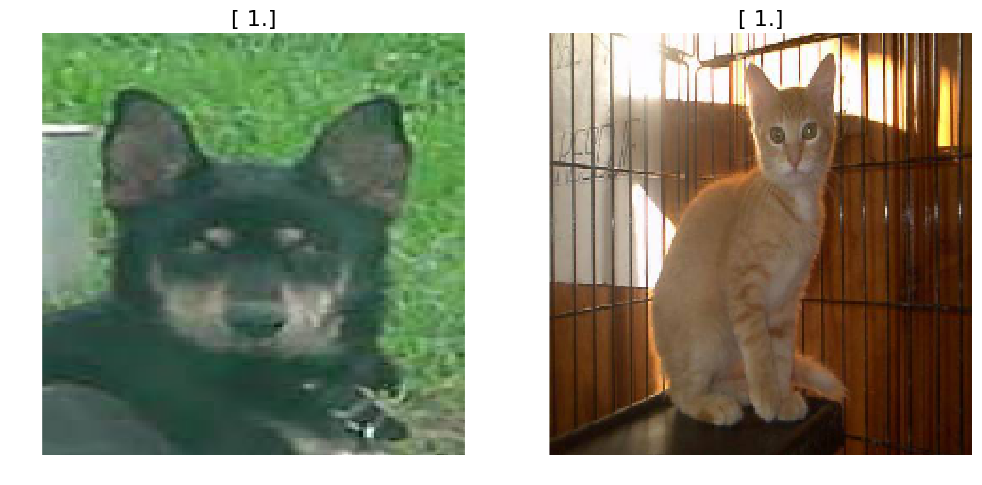

In [30]:
test_imgs, test_labels = next(test_batches)
plots(test_imgs, titles = test_labels)

In [27]:
vgg.predict(test_imgs, True)

(array([ 0.9978,  0.9986], dtype=float32), array([0, 0]), ['cats', 'cats'])

In [22]:
prediction = vgg.predict(test_imgs, True)

In [23]:
print prediction

(array([ 0.9175,  0.998 ,  0.7101,  0.9368], dtype=float32), array([1, 1, 0, 1]), ['dogs', 'dogs', 'cats', 'dogs'])


In [ ]:
for test_imgs, test_labels in test_batches:
    plots(test_imgs, titles = test_labels)